# Library

In [1]:
import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

from helper_train import train_conv_vae
from helper_plot import plot_vae

# Config

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 128
NUM_EPOCHS = 20
lr = 0.001

# Dataset

In [3]:

data_transform = transforms.Compose([transforms.ToTensor()])

mnist_train = MNIST('../Dataset', train = True, download = True, transform = data_transform, )
train_loader = DataLoader(dataset = mnist_train, batch_size = BATCH_SIZE, shuffle=True)

images, labels = next(iter(train_loader))
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


# Convolutional Variational Autoencoder

In [4]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential( 
                nn.Conv2d(1, 16, kernel_size = 3, stride = 2, padding = 1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(16, 32, kernel_size = 3, stride = 2, padding = 1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1),
                nn.LeakyReLU(0.01),
                nn.Flatten(),
        )

        self.z_mean = nn.Linear(3136, 16)
        self.z_log_var = nn.Linear(3136, 16)


        self.decoder = nn.Sequential(
                torch.nn.Linear(16, 3136),
                Reshape(-1, 64, 7, 7),
                nn.ConvTranspose2d(64, 32, kernel_size = 3, stride = 1, padding = 1),
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(32, 16, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),    
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(16, 1, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),
                nn.Sigmoid()        
        )
        
        
    def reparameterize(self, z_mu, Z_log_var):
        std = torch.exp(0.5 * Z_log_var).to(DEVICE)
        eps = torch.rand_like(std)
        z = z_mu + std * eps
        return z


    def forward(self, x):
        encoded = self.encoder(x)
        z_mean, z_log_var = self.z_mean(encoded), self.z_log_var(encoded)
        latent_vector = self.reparameterize(z_mean, z_log_var)
        decoded = self.decoder(latent_vector)
        return z_mean, z_log_var, decoded


model = VAE().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

# Training

In [7]:
train_conv_vae(model, train_loader, optimizer, NUM_EPOCHS)

100%|██████████| 469/469 [00:08<00:00, 55.99it/s]


Epoch: 001/020 | Loss: 10777.9604


100%|██████████| 469/469 [00:07<00:00, 60.31it/s]


Epoch: 002/020 | Loss: 10765.7170


100%|██████████| 469/469 [00:08<00:00, 53.77it/s]


Epoch: 003/020 | Loss: 10754.9725


100%|██████████| 469/469 [00:08<00:00, 53.76it/s]


Epoch: 004/020 | Loss: 10738.9825


100%|██████████| 469/469 [00:08<00:00, 52.72it/s]


Epoch: 005/020 | Loss: 10726.2282


100%|██████████| 469/469 [00:10<00:00, 42.97it/s]


Epoch: 006/020 | Loss: 10713.9197


100%|██████████| 469/469 [00:11<00:00, 42.25it/s]


Epoch: 007/020 | Loss: 10704.9109


100%|██████████| 469/469 [00:09<00:00, 50.16it/s]


Epoch: 008/020 | Loss: 10694.1293


100%|██████████| 469/469 [00:08<00:00, 54.38it/s]


Epoch: 009/020 | Loss: 10682.9601


100%|██████████| 469/469 [00:10<00:00, 43.78it/s]


Epoch: 010/020 | Loss: 10676.2876


100%|██████████| 469/469 [00:11<00:00, 42.15it/s]


Epoch: 011/020 | Loss: 10668.8564


100%|██████████| 469/469 [00:11<00:00, 42.23it/s]


Epoch: 012/020 | Loss: 10660.7882


100%|██████████| 469/469 [00:11<00:00, 42.02it/s]


Epoch: 013/020 | Loss: 10653.3357


100%|██████████| 469/469 [00:08<00:00, 55.95it/s]


Epoch: 014/020 | Loss: 10641.0556


100%|██████████| 469/469 [00:08<00:00, 55.19it/s]


Epoch: 015/020 | Loss: 10635.1489


100%|██████████| 469/469 [00:08<00:00, 54.07it/s]


Epoch: 016/020 | Loss: 10631.5414


100%|██████████| 469/469 [00:08<00:00, 54.62it/s]


Epoch: 017/020 | Loss: 10618.9582


100%|██████████| 469/469 [00:08<00:00, 52.78it/s]


Epoch: 018/020 | Loss: 10612.2888


100%|██████████| 469/469 [00:08<00:00, 54.30it/s]


Epoch: 019/020 | Loss: 10608.1804


100%|██████████| 469/469 [00:08<00:00, 55.72it/s]

Epoch: 020/020 | Loss: 10603.1877


# Evaluation

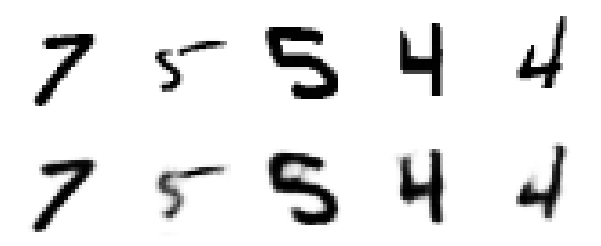

In [14]:
plot_vae(model, train_loader)